# ========================================
# Imports
# ========================================

In [1]:
import os
import random
import argparse
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


from tqdm.notebook import tqdm as tqdm_notebook
tqdm = tqdm_notebook
from sklearn.model_selection import train_test_split

import sys

sys.argv = ['']

print("Imports OK")

Imports OK


# ========================================
#  Split train/val par personne
# ========================================

In [11]:
def split_dataset(root_dir, val_ratio=0.2, seed=42):
    persons = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    valid_persons = []
    for p in persons:
        path = os.path.join(root_dir, p)
        files = [f for f in os.listdir(path) if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".bmp"))]
        if len(files) >= 2:
            valid_persons.append(p)
    
    train_persons, val_persons = train_test_split(
        valid_persons, test_size=val_ratio, random_state=seed
    )
    print(f"Total persons with >=2 images: {len(valid_persons)}")
    print(f"→ Train: {len(train_persons)} | Val: {len(val_persons)}")
    return train_persons, val_persons

# CONFIG
ROOT_DIR = '/home/marco/Projet_du_Fin_DEtude_M2/Datasets/sign_data/train'  
train_persons, val_persons = split_dataset(ROOT_DIR, val_ratio=0.2)

Total persons with >=2 images: 128
→ Train: 102 | Val: 26


# ========================================
#  Dataset
# ========================================

In [5]:
class SignaturePairsDataset(Dataset):
    def __init__(self, root_dir, allowed_persons, transform=None, num_pairs=5000, seed=42):
        self.root_dir = root_dir
        self.transform = transform
        self.num_pairs = num_pairs
        self.rng = random.Random(seed)

        self.data = {}
        for p in allowed_persons:
            path = os.path.join(root_dir, p)
            files = [
                os.path.join(path, f) for f in os.listdir(path)
                if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".bmp"))
            ]
            if len(files) >= 2:
                self.data[p] = sorted(files)

        self.persons = list(self.data.keys())
        if len(self.persons) < 2:
            raise RuntimeError("Not enough persons with 2+ images in allowed list")

        total_imgs = sum(len(v) for v in self.data.values())
        print(f"Dataset: {len(self.persons)} persons, {total_imgs} images, {num_pairs} pairs")

    def __len__(self):
        return self.num_pairs

    def __getitem__(self, idx):
        if self.rng.random() < 0.5:
            p = self.rng.choice(self.persons)
            a, b = self.rng.sample(self.data[p], 2)
            label = 1.0
        else:
            p1, p2 = self.rng.sample(self.persons, 2)
            a = self.rng.choice(self.data[p1])
            b = self.rng.choice(self.data[p2])
            label = 0.0

        img_a = Image.open(a)
        img_b = Image.open(b)
        if self.transform:
            img_a = self.transform(img_a)
            img_b = self.transform(img_b)
        return img_a, img_b, torch.tensor(label, dtype=torch.float32)

print("Dataset class ready")

Dataset class ready


# ========================================
# Modèle Siamois CNN
# ========================================

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, pool=True):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if pool:
            layers.append(nn.MaxPool2d(2))
        self.block = nn.Sequential(*layers)
    def forward(self, x):
        return self.block(x)

class LightweightSiamese(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            ConvBlock(1, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 256, pool=False),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(256, embedding_dim)

    def forward_once(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        emb = self.fc(x)
        return F.normalize(emb, p=2, dim=1)

    def forward(self, x1, x2):
        return self.forward_once(x1), self.forward_once(x2)

print("Model defined")

Model defined


# ========================================
# Loss + Validation
# ========================================

In [7]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
    def forward(self, emb1, emb2, label):
        dist = F.pairwise_distance(emb1, emb2)
        loss = label * dist.pow(2) + (1 - label) * F.relu(self.margin - dist).pow(2)
        return loss.mean()

def compute_val_metrics(model, loader, device):
    model.eval()
    dists, labels = [], []
    with torch.no_grad():
        for img1, img2, lbl in loader:
            img1, img2 = img1.to(device), img2.to(device)
            emb1, emb2 = model(img1, img2)
            dist = F.pairwise_distance(emb1, emb2)
            dists.append(dist.cpu().numpy())
            labels.append(lbl.numpy())
    dists = np.concatenate(dists).ravel()
    labels = np.concatenate(labels).ravel()
    threshold = 0.7
    acc = (dists < threshold) == labels
    acc = acc.mean() * 100
    pos_mean = dists[labels == 1].mean() if (labels == 1).any() else 0
    neg_mean = dists[labels == 0].mean() if (labels == 0).any() else 0
    return acc, pos_mean, neg_mean

class EarlyStopping:
    def __init__(self, patience=7, delta=0.5):
        self.patience = patience
        self.delta = delta
        self.best = None
        self.counter = 0
        self.early_stop = False
    def __call__(self, val_acc):
        if self.best is None:
            self.best = val_acc
        elif val_acc < self.best + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best = val_acc
            self.counter = 0

print("Loss, metrics, early stopping ready")

Loss, metrics, early stopping ready


# ========================================
# Collate + Config + Transforms + Datasets + Loaders
# ========================================

In [8]:
# Hyperparamètres
EPOCHS = 50
BATCH_SIZE = 32
PAIRS_TRAIN = 10000
PAIRS_VAL = 10000
LR = 5e-4
SAVE_PATH = 'siamese_best.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

IMG_SIZE = (224, 224)

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.RandomAffine(degrees=5, translate=(0.02, 0.02), shear=5),
    transforms.GaussianBlur(3, sigma=(0.1, 0.5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def siamese_collate_fn(batch):
    img1s = torch.stack([item[0] for item in batch])
    img2s = torch.stack([item[1] for item in batch])
    labels = torch.stack([item[2] for item in batch])
    return img1s, img2s, labels

# Datasets
train_ds = SignaturePairsDataset(ROOT_DIR, train_persons, train_transform, PAIRS_TRAIN)
val_ds = SignaturePairsDataset(ROOT_DIR, val_persons, val_transform, PAIRS_VAL)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, collate_fn=siamese_collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True, collate_fn=siamese_collate_fn)

print(f"Loaders ready: {len(train_loader)} batches train, {len(val_loader)} val")

Device: cuda
Dataset: 108 persons, 1409 images, 10000 pairs
Dataset: 20 persons, 240 images, 10000 pairs
Loaders ready: 313 batches train, 313 val


# ========================================
# Modèle + Optimisation
# ========================================

In [9]:
model = LightweightSiamese(embedding_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
criterion = ContrastiveLoss(margin=1.0)
scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
early_stopping = EarlyStopping(patience=10, delta=0.5)

print(f"Model: {sum(p.numel() for p in model.parameters()):,} params")

Model: 1,011,552 params


# ========================================
# Boucle d'entraînement
# ========================================

In [10]:
history = {'loss': [], 'val_acc': [], 'pos_dist': [], 'neg_dist': []}

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    n = 0
    for img1, img2, lbl in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        img1, img2, lbl = img1.to(device), img2.to(device), lbl.to(device)
        optimizer.zero_grad()

        if scaler:
            with torch.cuda.amp.autocast():
                emb1, emb2 = model(img1, img2)
                loss = criterion(emb1, emb2, lbl)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            emb1, emb2 = model(img1, img2)
            loss = criterion(emb1, emb2, lbl)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * img1.size(0)
        n += img1.size(0)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)


    
    epoch_loss = running_loss / n
    val_acc, pos_mean, neg_mean = compute_val_metrics(model, val_loader, device)
    scheduler.step(val_acc)

    # Enregistrement
    history['loss'].append(epoch_loss)
    history['val_acc'].append(val_acc)
    history['pos_dist'].append(pos_mean)
    history['neg_dist'].append(neg_mean)

    # Early stopping
    #early_stopping(val_acc)

    print(f"Epoch {epoch:2d} | Loss: {epoch_loss:.4f} | Val: {val_acc:5.2f}% | "
          f"Pos: {pos_mean:.3f} | Neg: {neg_mean:.3f} | ES: {early_stopping.counter}/{early_stopping.patience}")
    
    

    #if early_stopping.early_stop:
    #    print("Early stopping!")
     #   break

# Sauvegarde
torch.save(model.state_dict(), SAVE_PATH)
print(f"Model saved: {SAVE_PATH}")

Epoch 1/50:   0%|          | 0/313 [00:00<?, ?it/s]

/home/marco/marco/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch  1 | Loss: 0.1134 | Val: 77.03% | Pos: 0.292 | Neg: 0.756 | ES: 0/10


Epoch 2/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  2 | Loss: 0.0907 | Val: 74.65% | Pos: 0.268 | Neg: 0.786 | ES: 0/10


Epoch 3/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  3 | Loss: 0.0805 | Val: 73.91% | Pos: 0.252 | Neg: 0.808 | ES: 0/10


Epoch 4/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  4 | Loss: 0.0735 | Val: 79.30% | Pos: 0.272 | Neg: 0.880 | ES: 0/10


Epoch 5/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  5 | Loss: 0.0694 | Val: 77.91% | Pos: 0.267 | Neg: 0.864 | ES: 0/10


Epoch 6/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  6 | Loss: 0.0653 | Val: 84.87% | Pos: 0.301 | Neg: 0.966 | ES: 0/10


Epoch 7/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  7 | Loss: 0.0628 | Val: 82.29% | Pos: 0.312 | Neg: 0.940 | ES: 0/10


Epoch 8/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  8 | Loss: 0.0609 | Val: 80.91% | Pos: 0.279 | Neg: 0.901 | ES: 0/10


Epoch 9/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch  9 | Loss: 0.0582 | Val: 80.97% | Pos: 0.296 | Neg: 0.930 | ES: 0/10


Epoch 10/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.0562 | Val: 82.45% | Pos: 0.306 | Neg: 0.987 | ES: 0/10


Epoch 11/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11 | Loss: 0.0535 | Val: 83.75% | Pos: 0.312 | Neg: 0.991 | ES: 0/10


Epoch 12/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12 | Loss: 0.0510 | Val: 78.23% | Pos: 0.277 | Neg: 0.887 | ES: 0/10


Epoch 13/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13 | Loss: 0.0490 | Val: 86.82% | Pos: 0.325 | Neg: 1.058 | ES: 0/10


Epoch 14/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14 | Loss: 0.0467 | Val: 83.83% | Pos: 0.310 | Neg: 0.994 | ES: 0/10


Epoch 15/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15 | Loss: 0.0455 | Val: 84.02% | Pos: 0.318 | Neg: 0.981 | ES: 0/10


Epoch 16/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16 | Loss: 0.0432 | Val: 82.37% | Pos: 0.311 | Neg: 0.934 | ES: 0/10


Epoch 17/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17 | Loss: 0.0417 | Val: 85.27% | Pos: 0.341 | Neg: 1.029 | ES: 0/10


Epoch 18/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18 | Loss: 0.0397 | Val: 81.89% | Pos: 0.326 | Neg: 0.927 | ES: 0/10


Epoch 19/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19 | Loss: 0.0387 | Val: 73.45% | Pos: 0.272 | Neg: 0.798 | ES: 0/10


Epoch 20/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20 | Loss: 0.0373 | Val: 82.03% | Pos: 0.337 | Neg: 0.962 | ES: 0/10


Epoch 21/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21 | Loss: 0.0354 | Val: 84.89% | Pos: 0.367 | Neg: 1.068 | ES: 0/10


Epoch 22/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22 | Loss: 0.0343 | Val: 82.32% | Pos: 0.321 | Neg: 0.950 | ES: 0/10


Epoch 23/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23 | Loss: 0.0324 | Val: 81.86% | Pos: 0.346 | Neg: 0.986 | ES: 0/10


Epoch 24/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24 | Loss: 0.0310 | Val: 78.89% | Pos: 0.302 | Neg: 0.847 | ES: 0/10


Epoch 25/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25 | Loss: 0.0300 | Val: 76.68% | Pos: 0.300 | Neg: 0.830 | ES: 0/10


Epoch 26/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26 | Loss: 0.0288 | Val: 83.13% | Pos: 0.346 | Neg: 0.986 | ES: 0/10


Epoch 27/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27 | Loss: 0.0276 | Val: 77.36% | Pos: 0.297 | Neg: 0.860 | ES: 0/10


Epoch 28/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28 | Loss: 0.0273 | Val: 82.12% | Pos: 0.369 | Neg: 0.993 | ES: 0/10


Epoch 29/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29 | Loss: 0.0261 | Val: 85.31% | Pos: 0.393 | Neg: 1.052 | ES: 0/10


Epoch 30/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30 | Loss: 0.0245 | Val: 86.96% | Pos: 0.386 | Neg: 1.083 | ES: 0/10


Epoch 31/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 31 | Loss: 0.0244 | Val: 84.00% | Pos: 0.353 | Neg: 0.997 | ES: 0/10


Epoch 32/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 32 | Loss: 0.0231 | Val: 82.58% | Pos: 0.314 | Neg: 0.938 | ES: 0/10


Epoch 33/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 33 | Loss: 0.0225 | Val: 80.75% | Pos: 0.332 | Neg: 0.914 | ES: 0/10


Epoch 34/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 34 | Loss: 0.0216 | Val: 76.73% | Pos: 0.277 | Neg: 0.780 | ES: 0/10


Epoch 35/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35 | Loss: 0.0209 | Val: 73.94% | Pos: 0.259 | Neg: 0.723 | ES: 0/10


Epoch 36/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 36 | Loss: 0.0205 | Val: 72.22% | Pos: 0.258 | Neg: 0.700 | ES: 0/10


Epoch 37/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 37 | Loss: 0.0200 | Val: 76.13% | Pos: 0.277 | Neg: 0.787 | ES: 0/10


Epoch 38/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 38 | Loss: 0.0191 | Val: 84.14% | Pos: 0.325 | Neg: 0.985 | ES: 0/10


Epoch 39/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 39 | Loss: 0.0188 | Val: 81.86% | Pos: 0.314 | Neg: 0.895 | ES: 0/10


Epoch 40/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40 | Loss: 0.0187 | Val: 86.60% | Pos: 0.350 | Neg: 1.060 | ES: 0/10


Epoch 41/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 41 | Loss: 0.0174 | Val: 87.62% | Pos: 0.349 | Neg: 1.056 | ES: 0/10


Epoch 42/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 42 | Loss: 0.0169 | Val: 83.78% | Pos: 0.367 | Neg: 1.031 | ES: 0/10


Epoch 43/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 43 | Loss: 0.0168 | Val: 82.43% | Pos: 0.358 | Neg: 0.987 | ES: 0/10


Epoch 44/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 44 | Loss: 0.0166 | Val: 84.47% | Pos: 0.343 | Neg: 1.019 | ES: 0/10


Epoch 45/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 45 | Loss: 0.0157 | Val: 84.06% | Pos: 0.361 | Neg: 1.010 | ES: 0/10


Epoch 46/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 46 | Loss: 0.0152 | Val: 82.79% | Pos: 0.339 | Neg: 0.982 | ES: 0/10


Epoch 47/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 47 | Loss: 0.0147 | Val: 81.57% | Pos: 0.339 | Neg: 0.979 | ES: 0/10


Epoch 48/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 48 | Loss: 0.0150 | Val: 85.92% | Pos: 0.374 | Neg: 1.074 | ES: 0/10


Epoch 49/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 49 | Loss: 0.0145 | Val: 83.63% | Pos: 0.346 | Neg: 0.983 | ES: 0/10


Epoch 50/50:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 50 | Loss: 0.0146 | Val: 83.04% | Pos: 0.332 | Neg: 0.937 | ES: 0/10
Model saved: siamese_best.pth


# ========================================
# Visualisation des courbes
# ========================================

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['loss'], 'b-o', markersize=3)
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history['val_acc'], 'g-o', markersize=3)
plt.title('Validation Accuracy')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history['pos_dist'], 'b-o', label='Pos Dist', markersize=3)
plt.plot(history['neg_dist'], 'r-o', label='Neg Dist', markersize=3)
plt.title('Distances')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/home/marco/marco/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


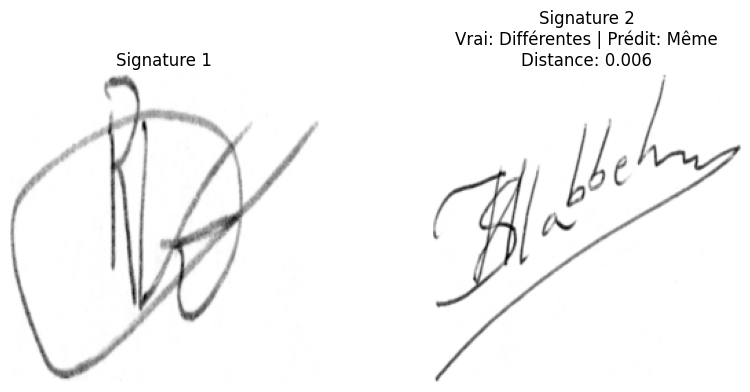

In [ ]:
model.eval()
with torch.no_grad():
    img1, img2, lbl = next(iter(val_loader))
    img1, img2 = img1[:1].to(device), img2[:1].to(device)
    emb1, emb2 = model(img1, img2)
    dist = F.pairwise_distance(emb1, emb2).item()
    pred = "Même" if dist < 0.8 else "Différentes"
    true = "Même" if lbl[0] == 1 else "Différentes"

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img1[0].cpu().numpy().squeeze(), cmap='gray')
    plt.title("Signature 1")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2[0].cpu().numpy().squeeze(), cmap='gray')
    plt.title(f"Signature 2\nVrai: {true} | Prédit: {pred}\nDistance: {dist:.3f}")
    plt.axis('off')
    plt.show()


# ========================================
#  Fonction compare() pour test manuel
# ========================================

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from datetime import datetime
from ultralytics import YOLO


# Dossier de sauvegarde
SAVE_DIR = "comparison_tests"
os.makedirs(SAVE_DIR, exist_ok=True)




def compare(img_path1, img_path2, show_crops=True, save_plot=True):
    """
    Compare deux images de CIN ou signatures.
    - Détecte la signature avec YOLO si c'est une CIN
    - Sinon, traite directement l'image comme une signature
    - Affiche + sauvegarde le résultat
    """
    model.eval()
    
    def load_and_crop(path):
        """Charge une image et extrait la signature si c'est une CIN"""
        if not os.path.exists(path):
            print(f"Erreur : Fichier non trouvé : {path}")
            return None, None
        
        # Charger avec OpenCV pour YOLO
        img_cv = cv2.imread(path)
        if img_cv is None:
            print(f"Erreur : Impossible de charger {path}")
            return None, None
        
        # Détection YOLO
        yolo_model = YOLO("home/marco/Projet_du_Fin_DEtude_M2/yolov8n.pt")
        
        results = yolo_model.predict(path, save=False, verbose=False, conf=0.5)
        crop_path = None
        for result in results:
            if result.boxes is not None:
                for box in result.boxes:
                    cls = int(box.cls[0].item())
                    if yolo_model.names.get(cls) == "signature":
                        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                        cropped = img_cv[y1:y2, x1:x2]
                        # Sauvegarde temporaire
                        temp_path = os.path.join(SAVE_DIR, f"temp_crop_{os.urandom(4).hex()}.png")
                        cv2.imwrite(temp_path, cropped)
                        crop_path = temp_path
                        break
                if crop_path:
                    break
        
        # Si pas de détection → on utilise l'image entière (cas signature directe)
        if crop_path is None:
            print(f"Aucune signature détectée dans {os.path.basename(path)} → utilisation de l'image entière")
            pil_img = Image.open(path).convert("L")
            pil_img = pil_img.resize((224, 224))
            temp_path = os.path.join(SAVE_DIR, f"temp_full_{os.urandom(4).hex()}.png")
            pil_img.save(temp_path)
            crop_path = temp_path
        
        return crop_path, img_cv

    # Charger et extraire
    print("Extraction des signatures...")
    sig1_path, img1_cv = load_and_crop(img_path1)
    sig2_path, img2_cv = load_and_crop(img_path2)
    
    if not sig1_path or not sig2_path:
        print("Erreur lors de l'extraction.")
        return

    # Transformer pour le modèle

    import torchvision.transforms as transforms

# Transformation pour le modèle Siamese (doit être identique à l'entraînement)
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    img1_pil = Image.open(sig1_path).convert("L")
    img2_pil = Image.open(sig2_path).convert("L")
    
    t1 = transform(img1_pil).unsqueeze(0).to(device)
    t2 = transform(img2_pil).unsqueeze(0).to(device)

    # Inférence
    with torch.no_grad():
        emb1, emb2 = model(t1, t2)
        dist = F.pairwise_distance(emb1, emb2).item()

    threshold = 0.8
    pred = "Même personne" if dist < threshold else "Personnes différentes"
    color = 'green' if dist < threshold else 'red'

    # === AFFICHAGE ===
    if show_crops:
        plt.figure(figsize=(14, 6))

        # Image originale 1
        plt.subplot(2, 3, 1)
        img1_rgb = cv2.cvtColor(img1_cv, cv2.COLOR_BGR2RGB)
        plt.imshow(img1_rgb)
        plt.title(f"CIN 1\n{os.path.basename(img_path1)}", fontsize=10)
        plt.axis('off')

        # Signature extraite 1
        plt.subplot(2, 3, 2)
        plt.imshow(img1_pil, cmap='gray')
        plt.title("Signature extraite", fontsize=10)
        plt.axis('off')

        # Image originale 2
        plt.subplot(2, 3, 4)
        img2_rgb = cv2.cvtColor(img2_cv, cv2.COLOR_BGR2RGB)
        plt.imshow(img2_rgb)
        plt.title(f"CIN 2\n{os.path.basename(img_path2)}", fontsize=10)
        plt.axis('off')

        # Signature extraite 2
        plt.subplot(2, 3, 5)
        plt.imshow(img2_pil, cmap='gray')
        plt.title("Signature extraite", fontsize=10)
        plt.axis('off')

        # Résultat
        plt.subplot(2, 3, 3)
        plt.text(0.5, 0.6, pred, ha='center', va='center', fontsize=16, fontweight='bold', color=color)
        plt.text(0.5, 0.4, f"Distance: {dist:.3f}", ha='center', va='center', fontsize=12)
        plt.text(0.5, 0.3, f"Seuil: {threshold}", ha='center', va='center', fontsize=10, color='gray')
        plt.axis('off')
        plt.title("Résultat de la comparaison", fontsize=12, pad=20)

        plt.subplot(2, 3, 6)
        plt.text(0.5, 0.5, "YOLO + Siamese", ha='center', va='center', fontsize=10, color='gray')
        plt.axis('off')

        plt.suptitle("Comparaison de Signatures", fontsize=16, fontweight='bold')
        plt.tight_layout()

        # Sauvegarde
        if save_plot:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_path = f"{SAVE_DIR}/comparison_{timestamp}.png"
            plt.savefig(save_path, dpi=200, bbox_inches='tight', facecolor='white')
            print(f"Résultat sauvegardé : {save_path}")

        plt.show()

    else:
        print(f"Résultat : {pred} | Distance = {dist:.3f}")

    # Nettoyage des crops temporaires
    for p in [sig1_path, sig2_path]:
        if p and 'temp_' in p and os.path.exists(p):
            try:
                os.remove(p)
            except:
                pass

    return dist, pred

Extraction des signatures...
Aucune signature détectée dans 01_0104051.PNG → utilisation de l'image entière
Aucune signature détectée dans 01_0106052.PNG → utilisation de l'image entière
Résultat sauvegardé : comparison_tests/comparison_20251115_141221.png


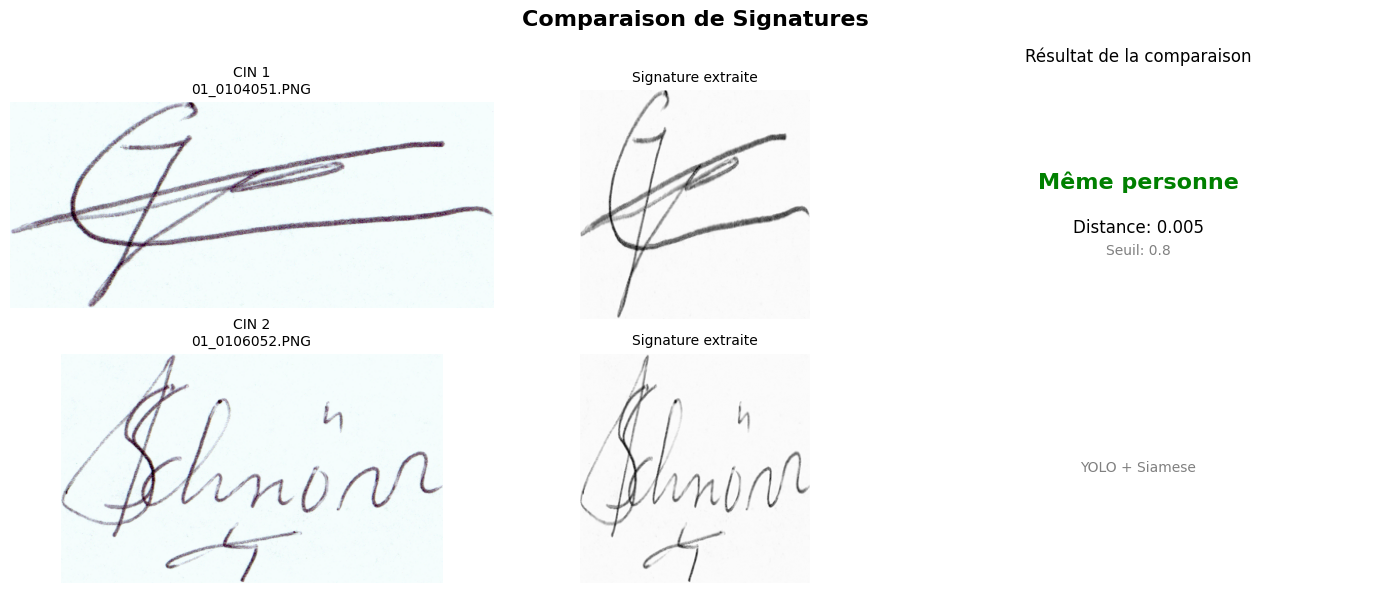

In [ ]:
# Exemple de test
dist, pred = compare(
    "/home/marco/Projet_du_Fin_DEtude_M2/Datasets/sign_data/test/persons6/01_0104051.PNG",
    "/home/marco/Projet_du_Fin_DEtude_M2/Datasets/sign_data/test/persons8/01_0106052.PNG"
)

# ========================================
#  Test sur 100 paires aléatoires du dossier test
# ========================================

In [ ]:

import random
from pathlib import Path

test_dir = "/home/marco/Projet_du_Fin_DEtude_M2/Datasets/CIN_data/images/test"
persons = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
person_paths = [os.path.join(test_dir, p) for p in persons]

correct = 0
total = 100

for _ in range(total):
    # 50% même personne, 50% différentes
    if random.random() < 0.5:
        p = random.choice(persons)
        path = os.path.join(test_dir, p)
        imgs = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', 'PNG'))]
        if len(imgs) >= 2:
            i1, i2 = random.sample(imgs, 2)
            path1 = os.path.join(path, i1)
            path2 = os.path.join(path, i2)
            true_label = 1
    else:
        p1, p2 = random.sample(persons, 2)
        imgs1 = os.listdir(os.path.join(test_dir, p1))
        imgs2 = os.listdir(os.path.join(test_dir, p2))
        path1 = os.path.join(test_dir, p1, random.choice(imgs1))
        path2 = os.path.join(test_dir, p2, random.choice(imgs2))
        true_label = 0

    dist, pred = compare(path1, path2, show_crops=False, save_plot=False)
    pred_label = 1 if "Même" in pred else 0
    if pred_label == true_label:
        correct += 1

print(f"\nAccuracy sur 100 tests : {correct/total*100:.1f}%")

ValueError: Sample larger than population or is negative